In [1]:
import os
import sys
import pickle
import argparse
import glob

import numpy as np
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, PILToTensor, ConvertImageDtype

ST_DIR = os.getcwd()
EXP_DIR = os.path.dirname(ST_DIR)
ROOT_DIR = os.path.dirname(EXP_DIR)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
sys.path.append(ROOT_DIR)

from core.posthoc.grad_cam import  plot_gradcam, grad_cam, postprocess_gcam
from core.transform import crop_ratio
from experiments.st._paths import DataPaths
from experiments.st.data_model import STImages
from sklearn.model_selection import StratifiedKFold
model = torch.load(os.path.join(DATA_DIR, 'model.pth'), map_location="cpu")

/home/heon/anaconda3/envs/breast/lib/python3.8/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


0.9987616539001465
0.997408926486969
0.9957970380783081
0.9677955508232117
0.9540880918502808
0.9453174471855164


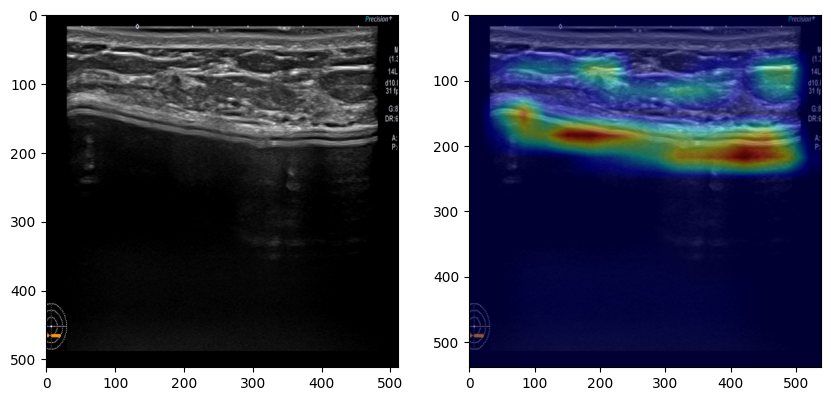

<Figure size 700x700 with 0 Axes>

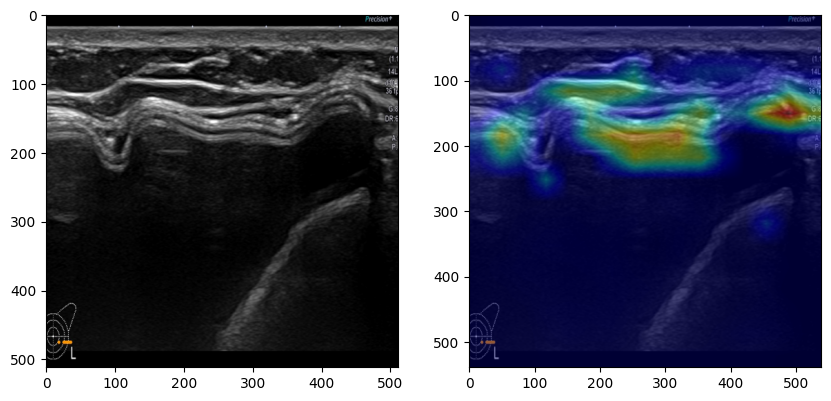

<Figure size 700x700 with 0 Axes>

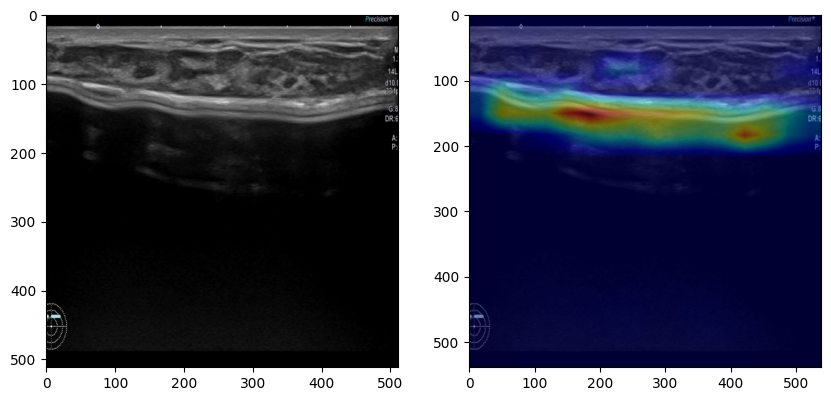

<Figure size 700x700 with 0 Axes>

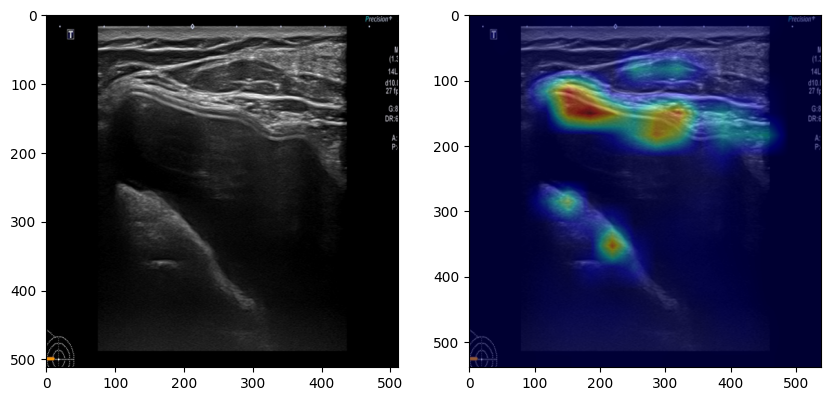

<Figure size 700x700 with 0 Axes>

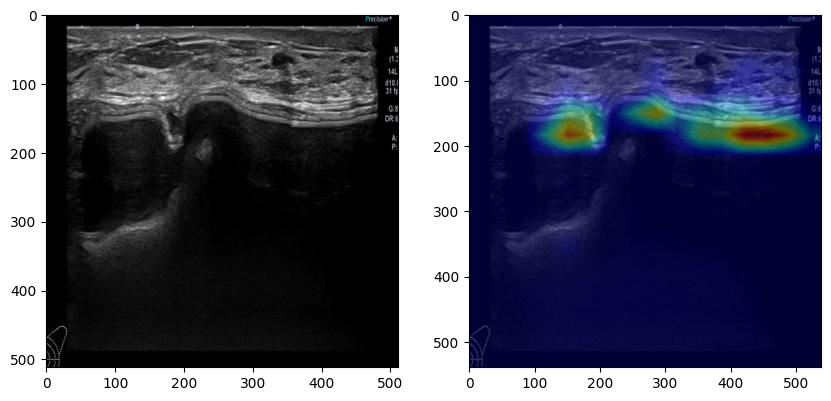

<Figure size 700x700 with 0 Axes>

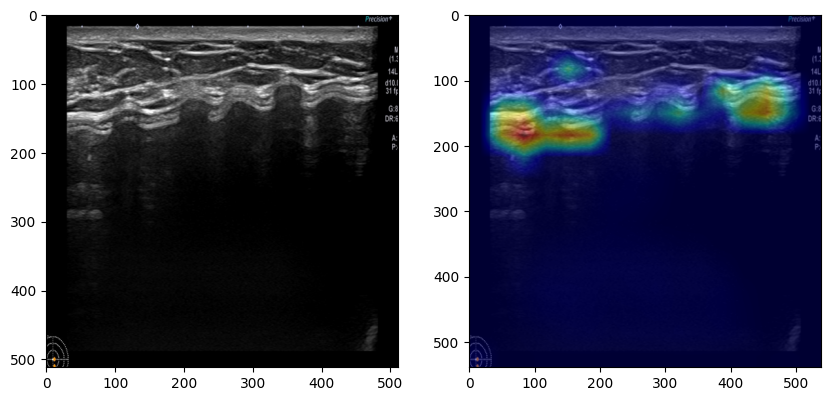

<Figure size 700x700 with 0 Axes>

In [2]:

import matplotlib as mpl
import tempfile

ARGS = argparse.Namespace()
ARGS.seed = 42
ARGS.device = "cpu"
ARGS.batch_size = 1
ARGS.num_workers = 1
data_paths = DataPaths(DATA_DIR)

def fig2rgb_array(fig):
    """adapted from: https://stackoverflow.com/questions/21939658/"""
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    print("to verify, our resolution is: ",ncols,nrows)
    return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)


canon_st_images = STImages(
    s_image_paths=glob.glob(str(data_paths.canon.s / "*")),
    t_image_paths=glob.glob(str(data_paths.canon.t / "*")),
)
transform = Compose(
    [PILToTensor(), Resize((512, 512)), ConvertImageDtype(torch.float)]
)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=ARGS.seed)

os.makedirs("./testset", exist_ok=True)

for fold, (train_indices, test_indices) in enumerate(
    stratified_kfold.split(canon_st_images.image_paths, canon_st_images.labels), start=1):
    
    if fold != 2:
        continue
    
    test_images = canon_st_images[test_indices]

    for i, (test_image, label) in enumerate(test_images):
        if label != 1:
            continue
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        image, (_, _) = crop_ratio(np.array(Image.open(test_image)), is_st=True)
        image_pil = Image.fromarray(image)
        cam, confidence = grad_cam(model, transform(image_pil).unsqueeze(0), model.layer4[-1])
        cam_post = postprocess_gcam(cam, image_pil.size)
        
        axes[0].imshow(np.array(image_pil.resize((512, 512))))
        camfig, gcam_ax = plot_gradcam(model, transform(image_pil).unsqueeze(0), np.array(image_pil.resize((512, 512))), model.layer4[-1])
        
        gcam_ax.axis('off')
        gcam_ax.set_title('')
        gcam_ax.figure.canvas.draw()
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
            camfig.savefig(temp_file.name, bbox_inches="tight", pad_inches=0.0)
            
        image_array = plt.imread(temp_file.name)
        temp_file.close()
        # gcam_image = camfig.canvas.renderer.buffer_rgba()
        axes[1].imshow(image_array)
        
        # image_array
        print(confidence)
        
        output_path = os.path.basename(test_image.replace("jpg", "gradcam.png"))
        fig.savefig(os.path.join("./testset", output_path))
        
        plt.cla()
        plt.clf()
        
        if i == 10:
            break


0.9775968194007874
0.6544280648231506
0.9808580279350281
0.8888154029846191
0.9892144799232483
0.976001501083374
0.9806187748908997
0.9734103679656982
0.9108496904373169
0.9812780022621155


/tmp/ipykernel_18660/737040701.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


0.9954415559768677


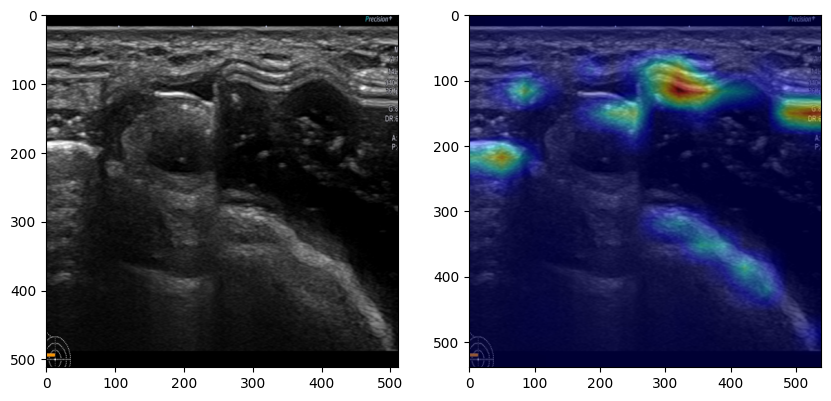

<Figure size 700x700 with 0 Axes>

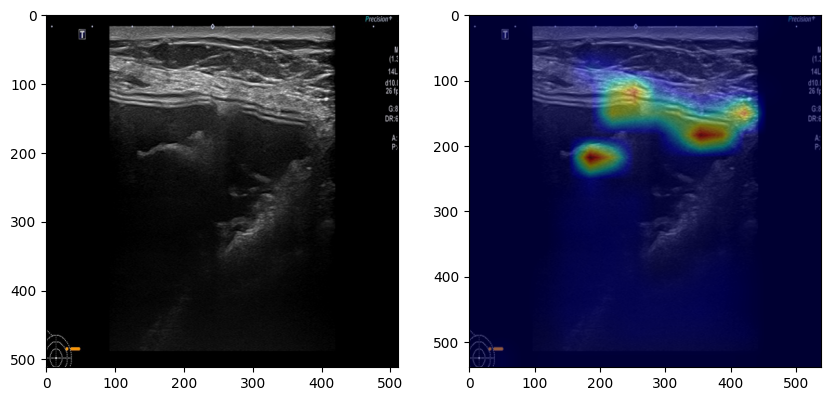

<Figure size 700x700 with 0 Axes>

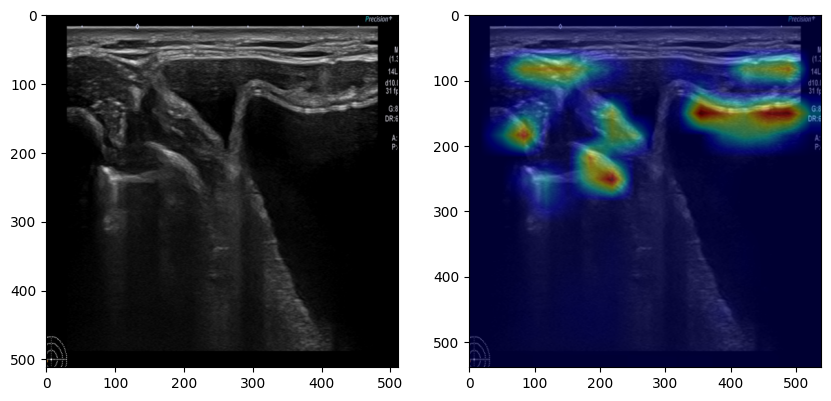

<Figure size 700x700 with 0 Axes>

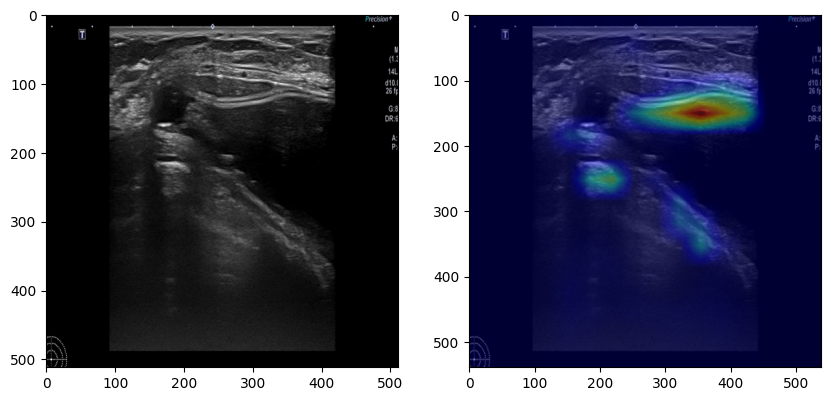

<Figure size 700x700 with 0 Axes>

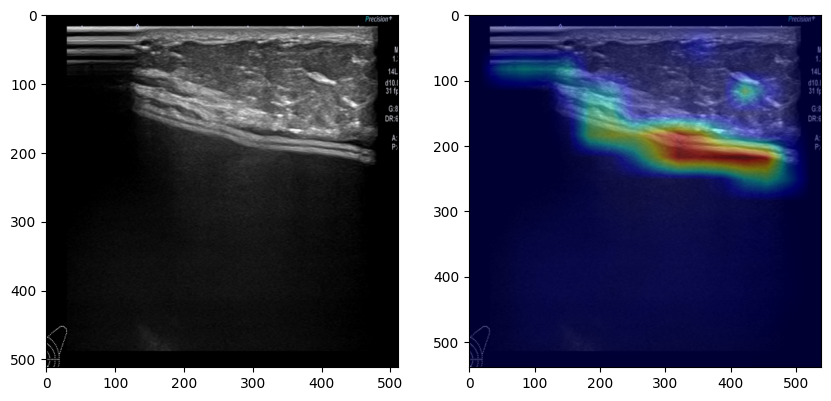

<Figure size 700x700 with 0 Axes>

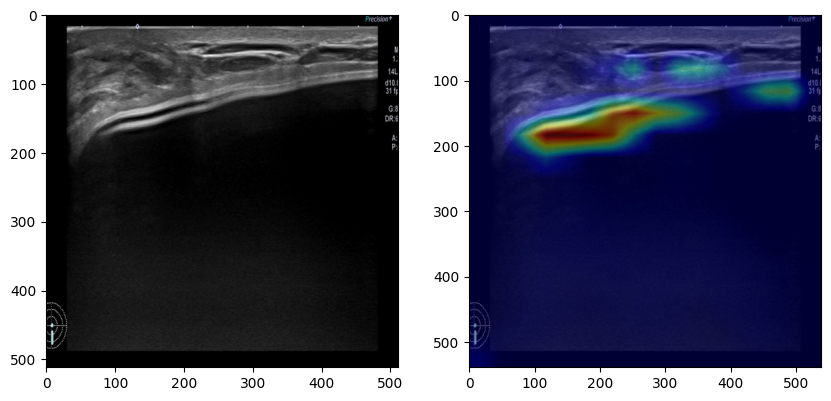

<Figure size 700x700 with 0 Axes>

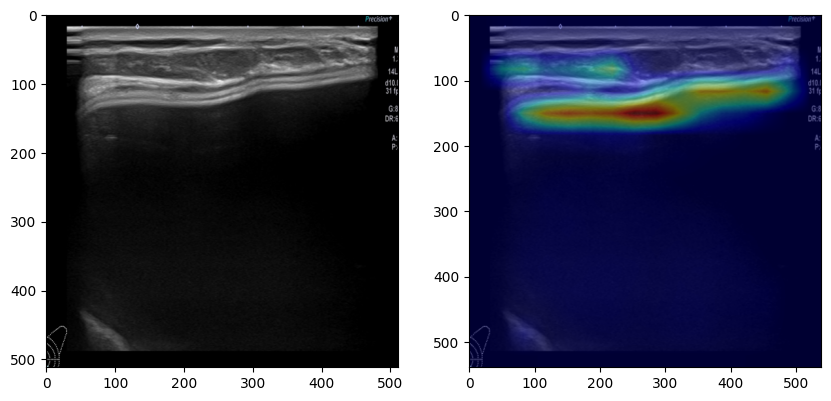

<Figure size 700x700 with 0 Axes>

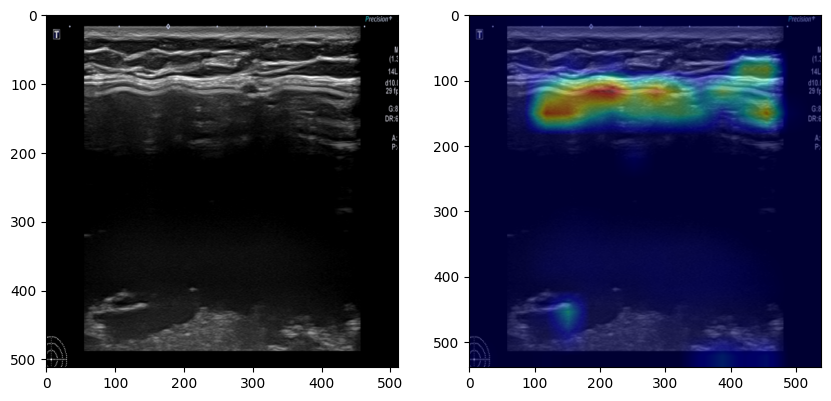

<Figure size 700x700 with 0 Axes>

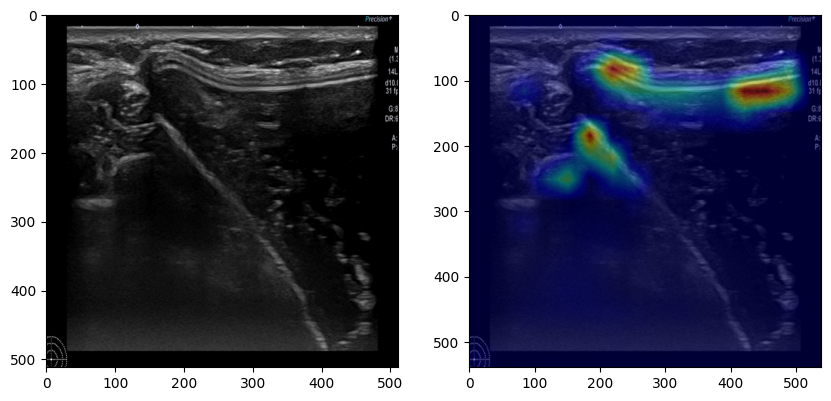

<Figure size 700x700 with 0 Axes>

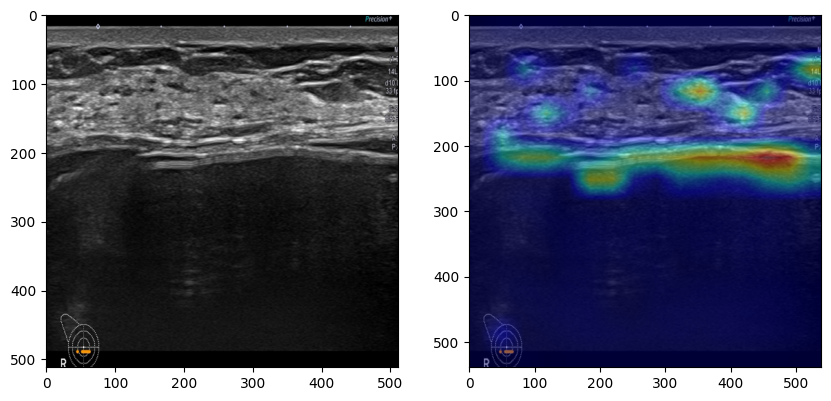

<Figure size 700x700 with 0 Axes>

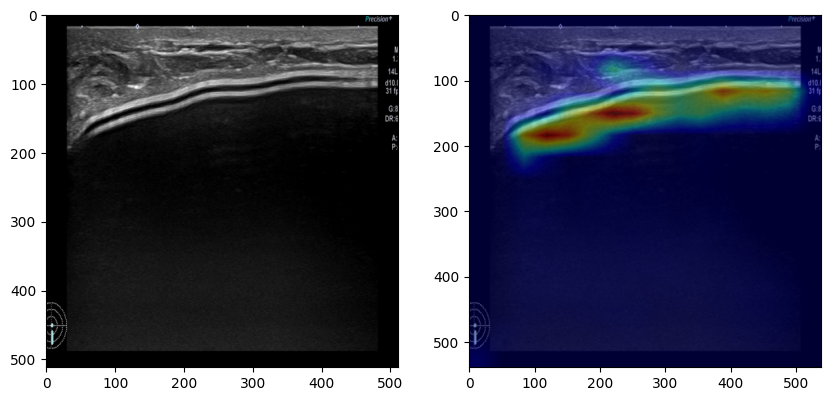

<Figure size 700x700 with 0 Axes>

In [3]:
rupture_st_images = STImages(
    s_image_paths=glob.glob(str(data_paths.canon_rupture.s / "*")),
    t_image_paths=glob.glob(str(data_paths.canon_rupture.t / "*")),
)

os.makedirs("./rupture", exist_ok=True)
for i, (rupture_image, label) in enumerate(rupture_st_images):

    if label != 1:
        continue
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    image, (_, _) = crop_ratio(np.array(Image.open(rupture_image)), is_st=True)
    image_pil = Image.fromarray(image)
    cam, confidence = grad_cam(model, transform(image_pil).unsqueeze(0), model.layer4[-1])
    cam_post = postprocess_gcam(cam, image_pil.size)
    axes[0].imshow(np.array(image_pil.resize((512, 512))))
    camfig, gcam_ax = plot_gradcam(model, transform(image_pil).unsqueeze(0), np.array(image_pil.resize((512, 512))), model.layer4[-1])

    gcam_ax.axis('off')
    gcam_ax.set_title('')
    gcam_ax.figure.canvas.draw()
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
        camfig.savefig(temp_file.name, bbox_inches="tight", pad_inches=0.0)
            
    image_array = plt.imread(temp_file.name)
    temp_file.close()
    # gcam_image = camfig.canvas.renderer.buffer_rgba()
    axes[1].imshow(image_array)
    
    # image_array
    print(confidence)
    
    output_path = os.path.basename(rupture_image.replace("jpg", "gradcam.png"))
    fig.savefig(os.path.join("./rupture", output_path))
    
    plt.cla()
    plt.clf()
    
    if i == 10:
        break
    